### Data Dictionary


    Month = the month of the year for the observation (1 = January, 2 = February, 3 = March, ...).
    Year = the year of the observation.
    ElantraSales = the number of units of the Hyundai Elantra sold in the United States in the given month.
    Unemployment = the estimated unemployment percentage in the United States in the given month.
    Queries = a (normalized) approximation of the number of Google searches for "hyundai elantra" in the given month.
    CPI_energy = the monthly consumer price index (CPI) for energy for the given month.
    CPI_all = the consumer price index (CPI) for all products for the given month; this is a measure of the magnitude of the prices paid by consumer households for goods and services (e.g., food, clothing, electricity, etc.).


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("elantra.csv")

In [3]:
df

,Month,Year,ElantraSales,Unemployment,Queries,CPI_energy,CPI_all
0,1,2010,7690,9.7,153,213.377,217.466
1,1,2011,9659,9.1,259,229.353,221.082
2,1,2012,10900,8.2,354,244.178,227.666
3,1,2013,12174,7.9,230,242.560,231.321
4,1,2014,15326,6.6,232,247.575,234.933
5,2,2010,7966,9.8,130,209.924,217.251
6,2,2011,12289,9.0,266,232.188,221.816
7,2,2012,13820,8.3,296,247.615,228.138
8,2,2013,16219,7.7,239,252.639,232.599
9,2,2014,16393,6.7,240,246.389,235.169


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Month         50 non-null     int64  
 1   Year          50 non-null     int64  
 2   ElantraSales  50 non-null     int64  
 3   Unemployment  50 non-null     float64
 4   Queries       50 non-null     int64  
 5   CPI_energy    50 non-null     float64
 6   CPI_all       50 non-null     float64
dtypes: float64(3), int64(4)
memory usage: 2.9 KB


In [5]:
df.describe(include='all')

,Month,Year,ElantraSales,Unemployment,Queries,CPI_energy,CPI_all
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.300000,2011.600000,16005.440000,8.422000,263.480000,236.945280,226.739040
std,3.558548,1.212183,4887.924676,0.951538,77.982007,15.393399,5.942194
min,1.000000,2010.000000,7690.000000,6.600000,130.000000,204.161000,217.251000
25%,3.000000,2011.000000,12560.500000,7.725000,224.750000,230.061750,221.265500
50%,6.000000,2012.000000,15624.500000,8.250000,262.500000,244.388000,227.902000
75%,9.000000,2013.000000,19197.250000,9.100000,311.000000,247.061750,231.693250
max,12.000000,2014.000000,26153.000000,9.900000,427.000000,256.389000,235.169000


In [6]:
df.shape

(50, 7)

In [7]:
df.columns

Index(['Month', 'Year', 'ElantraSales', 'Unemployment', 'Queries',
       'CPI_energy', 'CPI_all'],
      dtype='object')

### Data Visualization

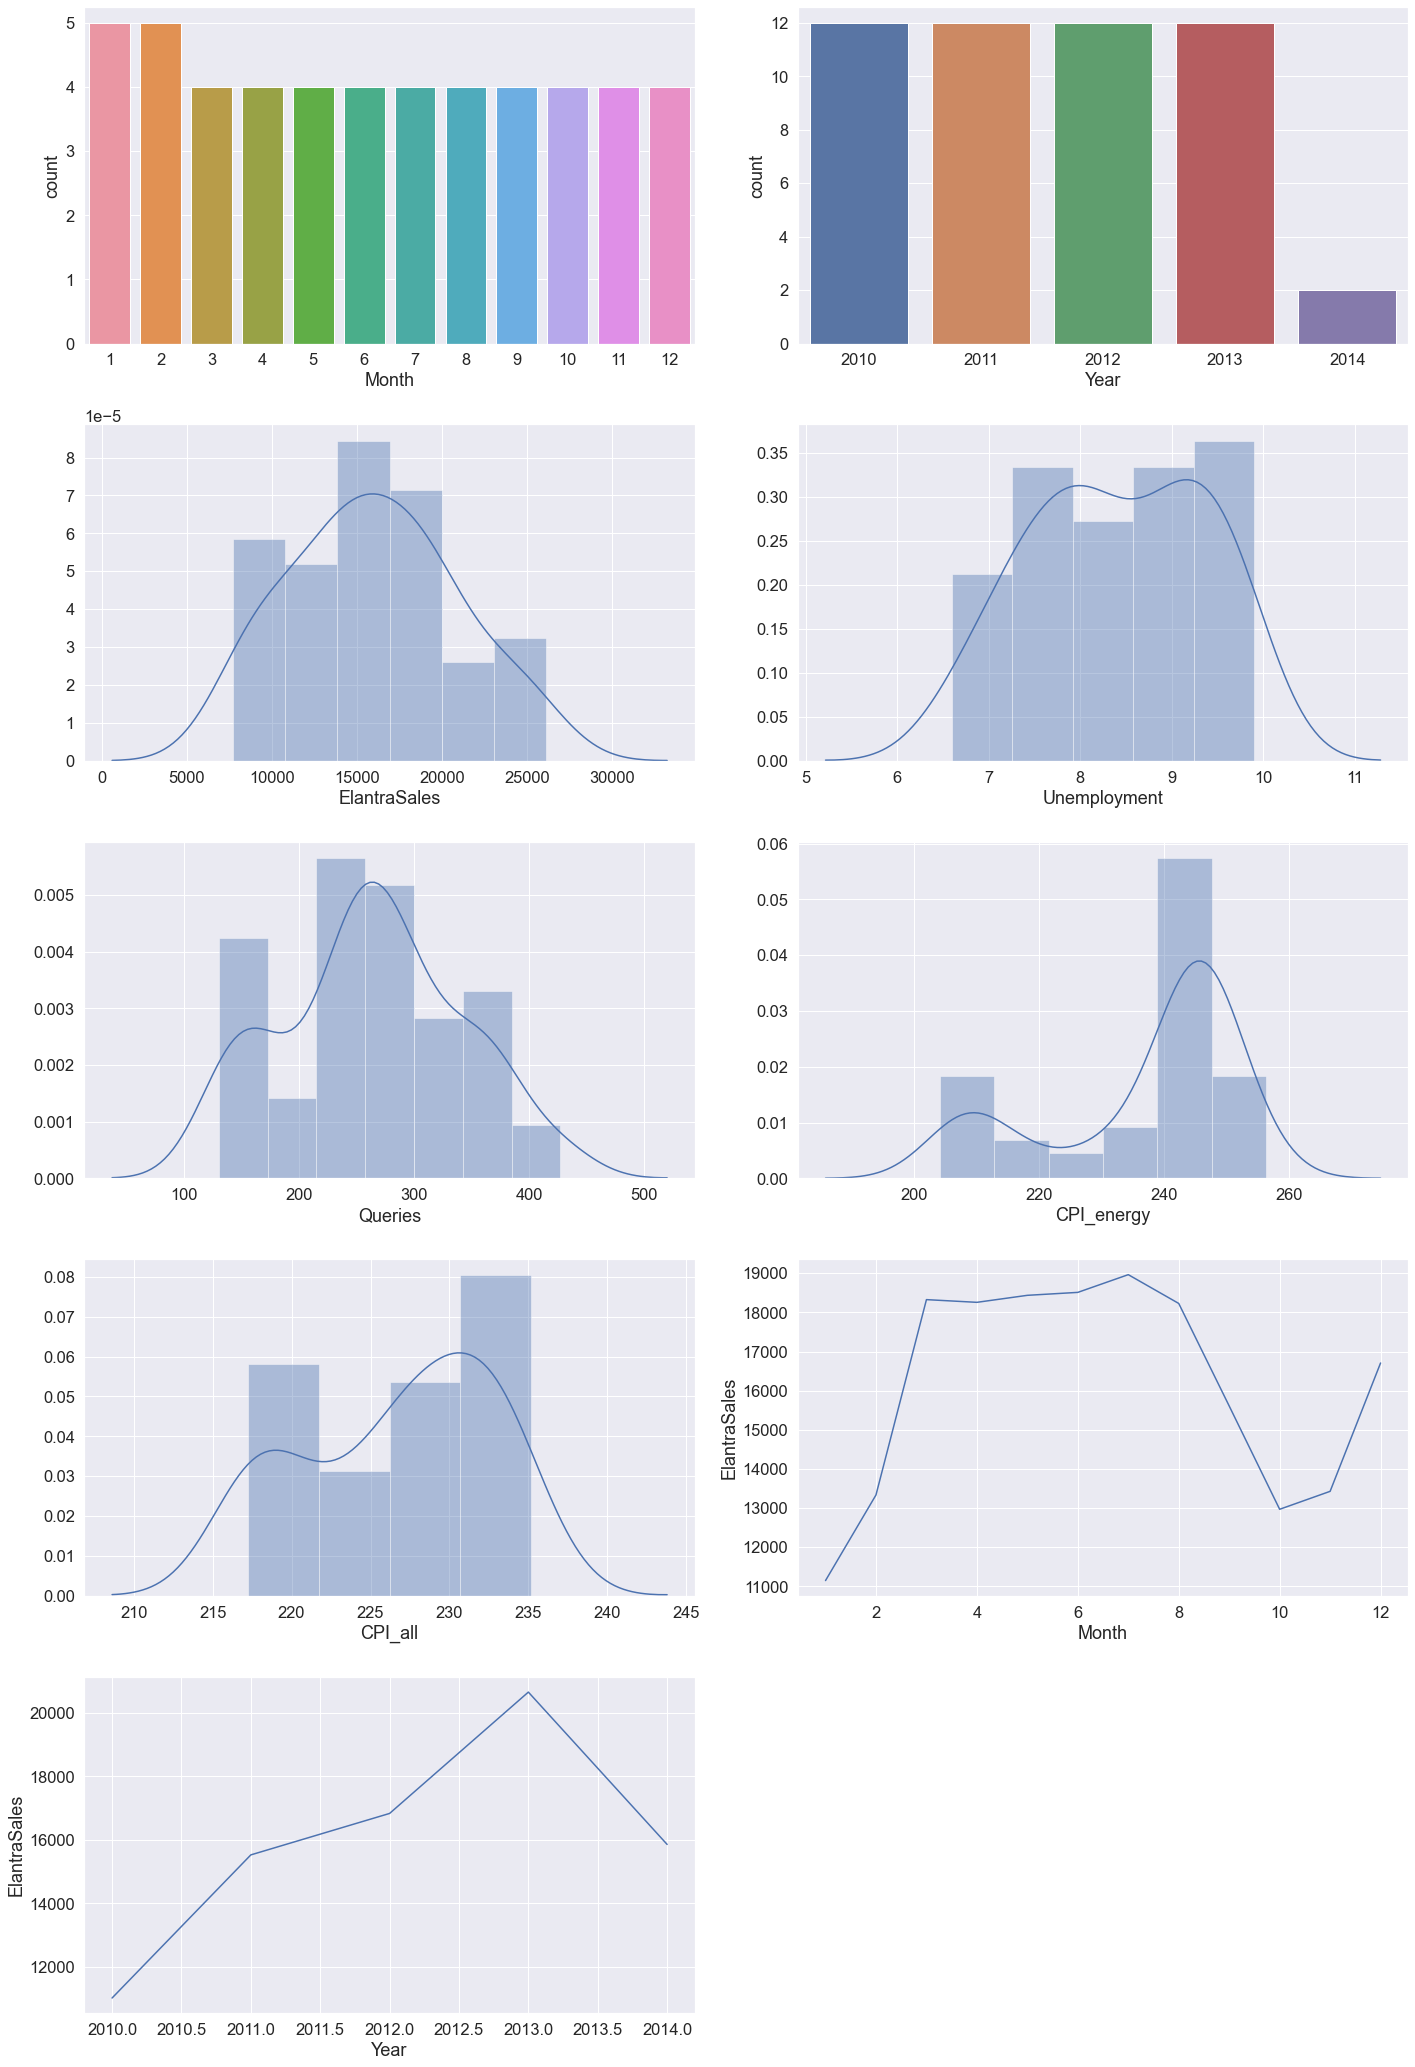

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Month)
plt.subplot(7,2,2)
sns.countplot(df.Year)
plt.subplot(7,2,3)
sns.distplot(df.ElantraSales)
plt.subplot(7,2,4)
sns.distplot(df.Unemployment)
plt.subplot(7,2,5)
sns.distplot(df.Queries)
plt.subplot(7,2,6)
sns.distplot(df.CPI_energy)
plt.subplot(7,2,7)
sns.distplot(df.CPI_all)
plt.subplot(7,2,8)
sns.lineplot(x=df.Month,y=df.ElantraSales,ci=None)
plt.subplot(7,2,9)
sns.lineplot(x=df.Year,y=df.ElantraSales,ci=None)
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,Month,Year,ElantraSales,Unemployment,Queries,CPI_energy,CPI_all
Month,1.000000,-0.113547,0.071402,-0.066478,0.036977,0.097092,0.114893
Year,-0.113547,1.000000,0.622075,-0.972425,0.381183,0.714229,0.955978
ElantraSales,0.071402,0.622075,1.000000,-0.623506,0.480180,0.544328,0.640257
Unemployment,-0.066478,-0.972425,-0.623506,1.000000,-0.349408,-0.701494,-0.963583
Queries,0.036977,0.381183,0.480180,-0.349408,1.000000,0.760016,0.508056
CPI_energy,0.097092,0.714229,0.544328,-0.701494,0.760016,1.000000,0.840991
CPI_all,0.114893,0.955978,0.640257,-0.963583,0.508056,0.840991,1.000000


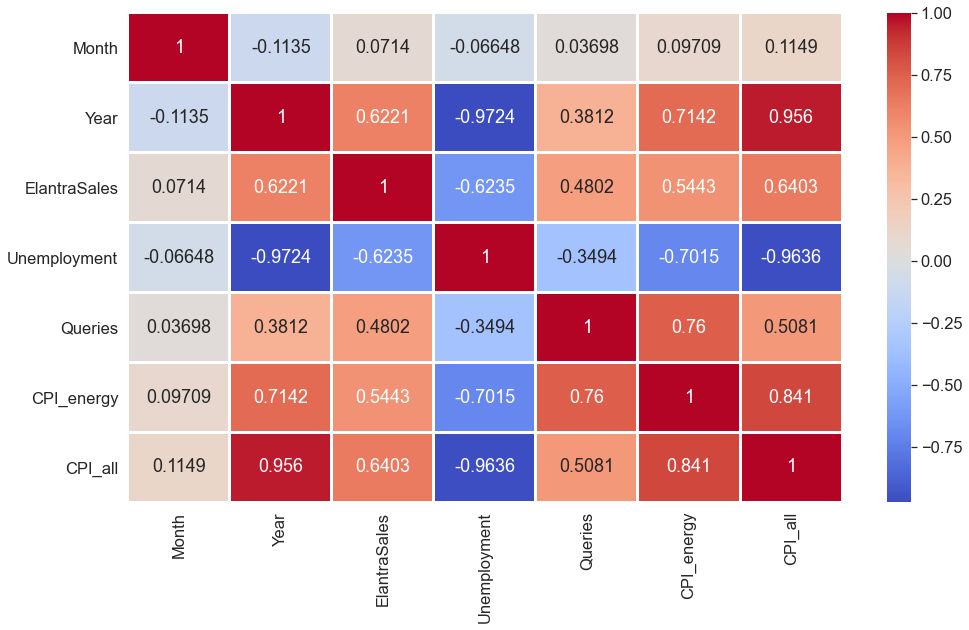

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.4g',linewidths=2)
plt.show()

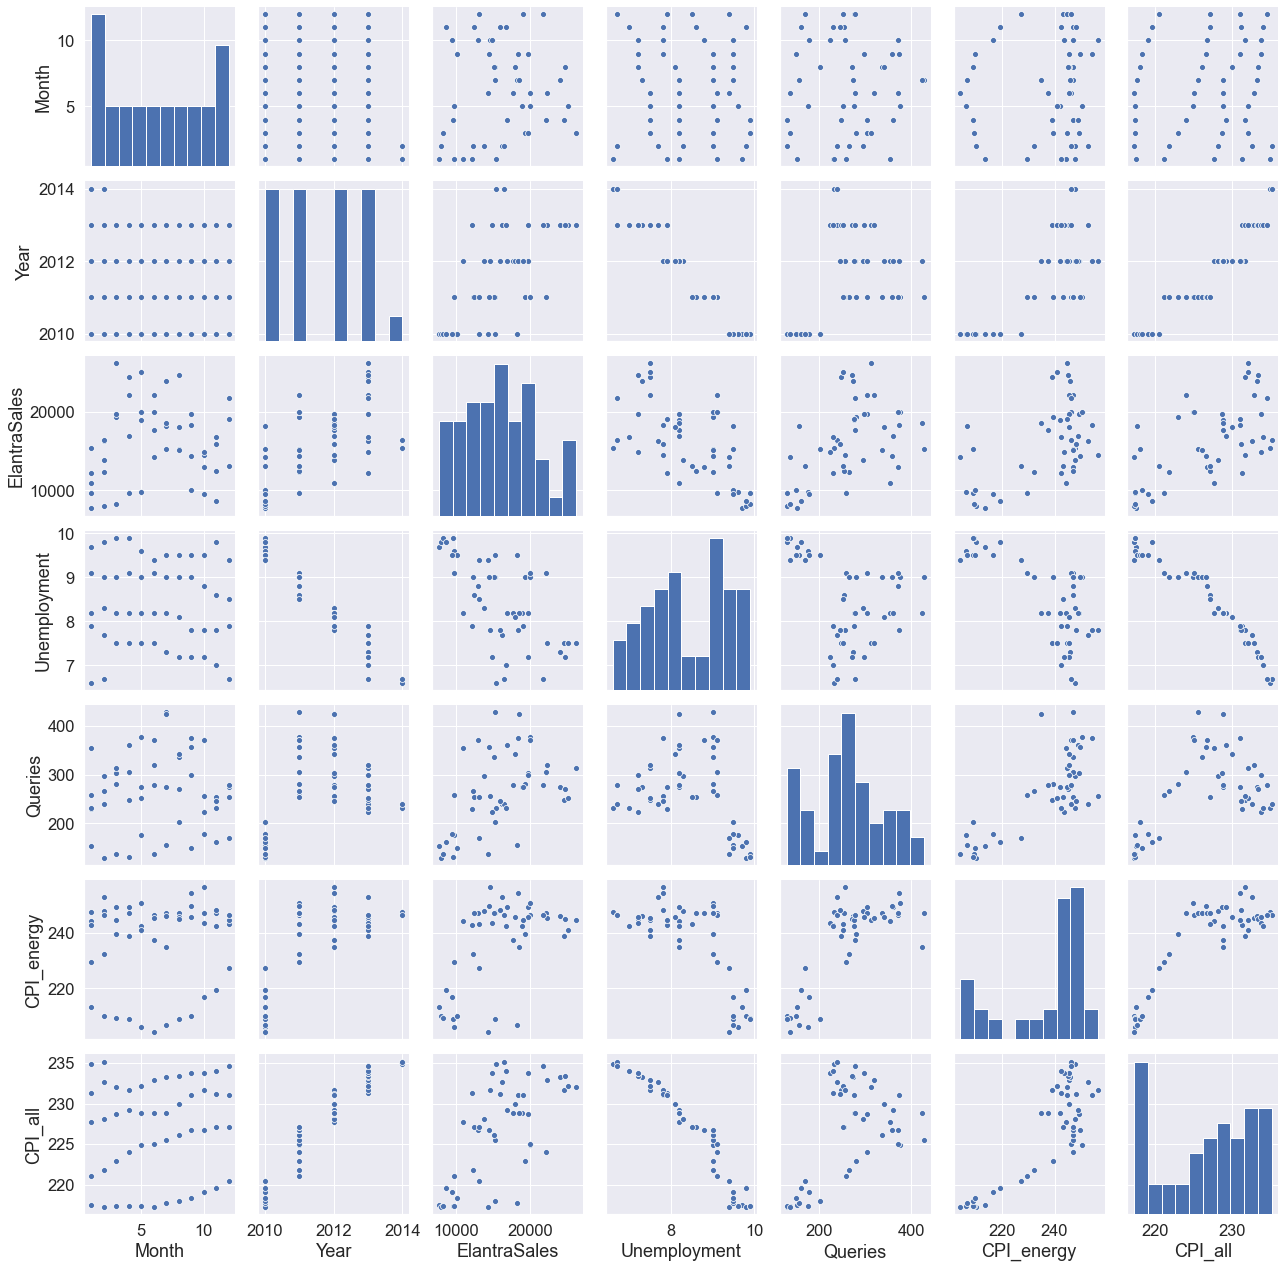

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Month           0
Year            0
ElantraSales    0
Unemployment    0
Queries         0
CPI_energy      0
CPI_all         0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

In [14]:
# df = df.sample(frac=1).reset_index(drop=True)

### Treat Outliers

In [15]:
df.describe()

,Month,Year,ElantraSales,Unemployment,Queries,CPI_energy,CPI_all
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.300000,2011.600000,16005.440000,8.422000,263.480000,236.945280,226.739040
std,3.558548,1.212183,4887.924676,0.951538,77.982007,15.393399,5.942194
min,1.000000,2010.000000,7690.000000,6.600000,130.000000,204.161000,217.251000
25%,3.000000,2011.000000,12560.500000,7.725000,224.750000,230.061750,221.265500
50%,6.000000,2012.000000,15624.500000,8.250000,262.500000,244.388000,227.902000
75%,9.000000,2013.000000,19197.250000,9.100000,311.000000,247.061750,231.693250
max,12.000000,2014.000000,26153.000000,9.900000,427.000000,256.389000,235.169000


In [16]:
# windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
#                          variables=[])

### Treat Data Types

### Feature Scaling

In [17]:
df.columns

Index(['Month', 'Year', 'ElantraSales', 'Unemployment', 'Queries',
       'CPI_energy', 'CPI_all'],
      dtype='object')

In [18]:
df.drop(['Month', 'Year'],axis=1, inplace=True)

In [19]:
df

,ElantraSales,Unemployment,Queries,CPI_energy,CPI_all
0,7690,9.7,153,213.377,217.466
1,9659,9.1,259,229.353,221.082
2,10900,8.2,354,244.178,227.666
3,12174,7.9,230,242.560,231.321
4,15326,6.6,232,247.575,234.933
5,7966,9.8,130,209.924,217.251
6,12289,9.0,266,232.188,221.816
7,13820,8.3,296,247.615,228.138
8,16219,7.7,239,252.639,232.599
9,16393,6.7,240,246.389,235.169


### Create and save processed dataset

In [20]:
# df.to_csv("",index=False)

### Model Training

In [21]:
X = df.iloc[:,1:5]
y = df.iloc[:,0]

In [22]:
X.values, y.values

(array([[  9.7  , 153.   , 213.377, 217.466],
        [  9.1  , 259.   , 229.353, 221.082],
        [  8.2  , 354.   , 244.178, 227.666],
        [  7.9  , 230.   , 242.56 , 231.321],
        [  6.6  , 232.   , 247.575, 234.933],
        [  9.8  , 130.   , 209.924, 217.251],
        [  9.   , 266.   , 232.188, 221.816],
        [  8.3  , 296.   , 247.615, 228.138],
        [  7.7  , 239.   , 252.639, 232.599],
        [  6.7  , 240.   , 246.389, 235.169],
        [  9.9  , 138.   , 209.163, 217.305],
        [  9.   , 281.   , 239.454, 222.955],
        [  8.2  , 303.   , 249.095, 228.732],
        [  7.5  , 313.   , 244.598, 232.075],
        [  9.9  , 132.   , 209.024, 217.376],
        [  9.1  , 305.   , 247.129, 224.056],
        [  8.2  , 361.   , 249.075, 229.184],
        [  7.5  , 248.   , 238.86 , 231.707],
        [  9.6  , 177.   , 206.172, 217.299],
        [  9.   , 376.   , 250.538, 224.918],
        [  8.2  , 275.   , 242.208, 228.884],
        [  7.5  , 252.   , 240.972

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 4), (10, 4), (40,), (10,))

In [25]:
xgb = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [26]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:13047.7
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:11703.9
[2]	validation_0-rmse:10531.1
[3]	validation_0-rmse:9434.93
[4]	validation_0-rmse:8574.09
[5]	validation_0-rmse:7701.5
[6]	validation_0-rmse:7012.4
[7]	validation_0-rmse:6365.38
[8]	validation_0-rmse:5825.08
[9]	validation_0-rmse:5347.52
[10]	validation_0-rmse:4992.49
[11]	validation_0-rmse:4607.51
[12]	validation_0-rmse:4277.24
[13]	validation_0-rmse:3971.86
[14]	validation_0-rmse:3719.53
[15]	validation_0-rmse:3480.51
[16]	validation_0-rmse:3341.17
[17]	validation_0-rmse:3239.12
[18]	validation_0-rmse:3095.29
[19]	validation_0-rmse:3044.02
[20]	validation_0-rmse:2969.05
[21]	validation_0-rmse:2945.33
[22]	validation_0-rmse:2883.6
[23]	validation_0-rmse:2886.76
[24]	validation_0-rmse:2852.73
[25]	validation_0-rmse:2826.68
[26]	validation_0-rmse:2840.4
[27]	validation_0-rmse:2823.69
[28]	validation_0-rmse:2842.31
[29]	validation_0-rmse:2827.11
[30]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
y_pred = xgb.predict(X_test)

In [28]:
y_pred

array([14757.285, 16390.379,  8756.125, 13357.668, 16709.906, 17565.646,
       12053.13 , 14690.36 , 11322.531, 15764.964], dtype=float32)

### Model Evaluation

In [29]:
mse = mean_squared_error(y_test,y_pred)
mse

7973245.962375546

In [30]:
rmse = np.sqrt(mse)
rmse

2823.6936736083017

In [31]:
r2score = r2_score(y_test,y_pred)
r2score

0.313760155389761

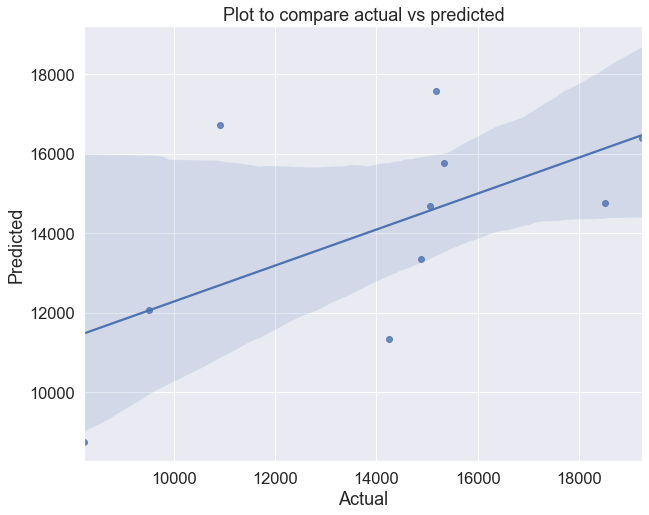

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

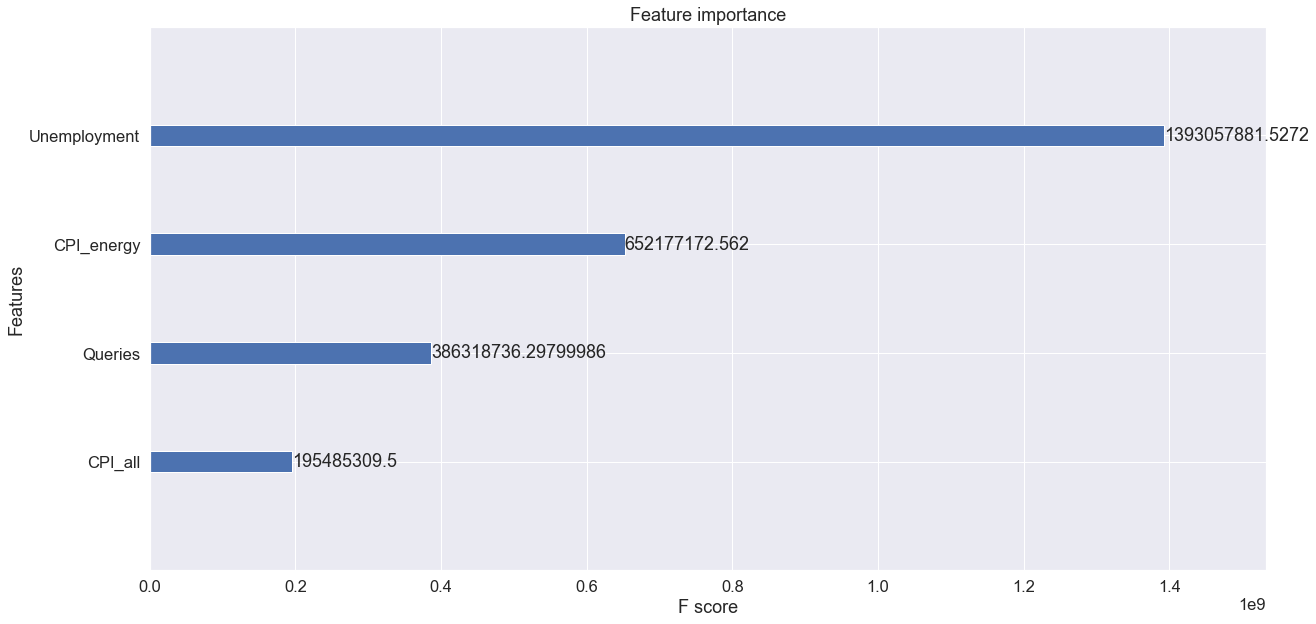

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [34]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [35]:
cv.mean()

0.2646987084081786